In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns

# Define the KL divergence function with epsilon for smoothing
def kl_divergence(p, q, epsilon=1e-10):
    p = np.asarray(p) + epsilon
    q = np.asarray(q) + epsilon
    return np.sum(p * np.log(p / q))

# Function to process text and calculate word probability distribution with add-one smoothing
def process_text(file_path, exclude_characters=[]):
    with open(file_path, 'r', encoding='utf-8') as file:
        lines = file.readlines()

    # Preprocess text (you may need to adjust this based on your specific requirements)
    words = [word.lower() for line in lines for word in line.split() if word.lower() not in exclude_characters]

    # Calculate word frequencies with add-one smoothing
    word_freq = Counter(words)
    total_words = len(words)
    prob_dist = {word: (freq + 1) / (total_words + len(word_freq)) for word, freq in word_freq.items()}

    return prob_dist

# Function to compare characters and calculate KL divergence with add-one smoothing
def compare_characters_kl_divergence_smoothed(character1_path, character2_path, exclude_characters=[]):
    # Process text for each character (excluding character names)
    prob_dist_char1 = process_text(character1_path, exclude_characters)
    prob_dist_char2 = process_text(character2_path, exclude_characters)

    # Get the unique words from both characters
    all_words = set(prob_dist_char1.keys()) | set(prob_dist_char2.keys())

    # Create probability distributions for KL divergence calculation
    prob_dist1 = np.array([prob_dist_char1.get(word, 0) for word in all_words])
    prob_dist2 = np.array([prob_dist_char2.get(word, 0) for word in all_words])

    # Calculate KL divergence
    divergence = kl_divergence(prob_dist1, prob_dist2)

    return divergence

# Characters to compare
characters = ['Chandler', 'Ross', 'Joey', 'Monica', 'Rachel', 'Phoebe']

# Directory for Season 1 character lines
season1_directory = '/home/jesse/code/Self_Learning/Python/Data_Science/Friends_analysis/Full_seasonwise/Season_1'

# Create a matrix to store KL divergences
divergence_matrix = np.zeros((len(characters), len(characters)))

# Compare characters and fill the matrix (excluding character names)
for i, char1 in enumerate(characters):
    for j, char2 in enumerate(characters):
        if i != j:
            char1_path = os.path.join(season1_directory, f'{char1}_lines.txt')
            char2_path = os.path.join(season1_directory, f'{char2}_lines.txt')
            divergence_matrix[i, j] = compare_characters_kl_divergence_smoothed(char1_path, char2_path, exclude_characters=[char.lower() for char in characters])


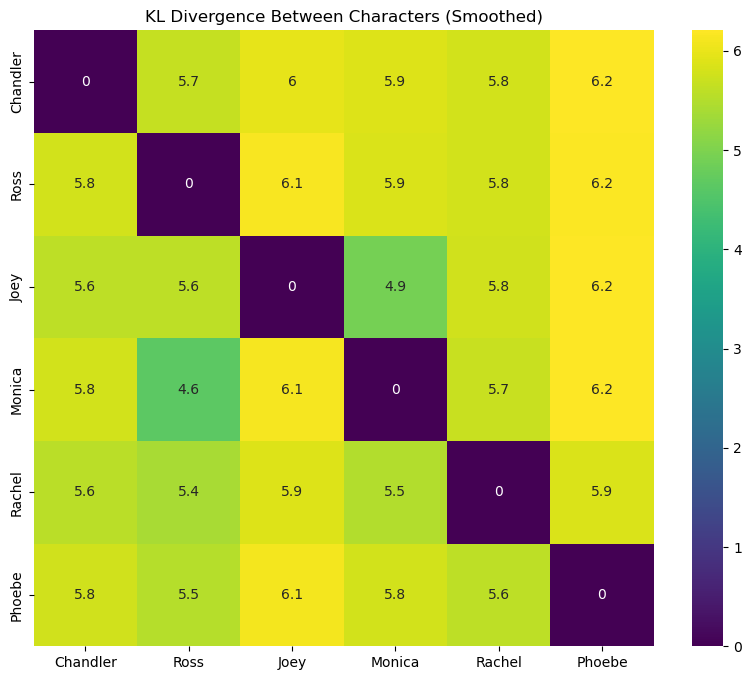

In [2]:
# Visualize the KL divergence matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(divergence_matrix, annot=True, cmap='viridis', xticklabels=characters, yticklabels=characters)
plt.title('KL Divergence Between Characters (Smoothed)')
plt.show()

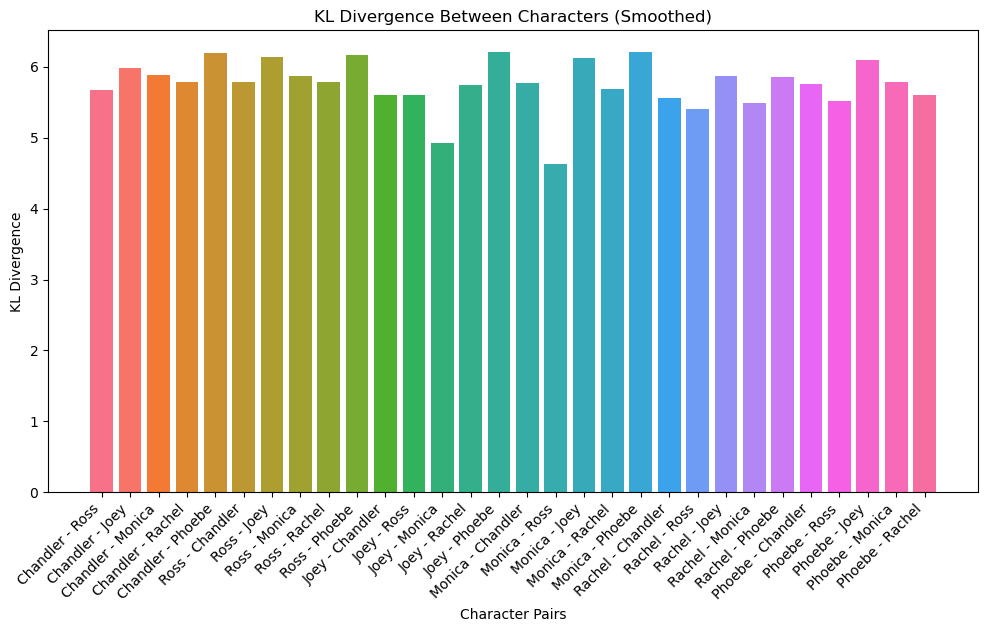

In [3]:
# Create a bar chart with different colors for each character pair
plt.figure(figsize=(12, 6))
colors = sns.color_palette('husl', n_colors=len(characters) * (len(characters) - 1))
for i, char1 in enumerate(characters):
    for j, char2 in enumerate(characters):
        if i != j:
            plt.bar(f'{char1} - {char2}', divergence_matrix[i, j], color=colors.pop(0))
plt.title('KL Divergence Between Characters (Smoothed)')
plt.xlabel('Character Pairs')
plt.ylabel('KL Divergence')
plt.xticks(rotation=45, ha='right')
plt.show()


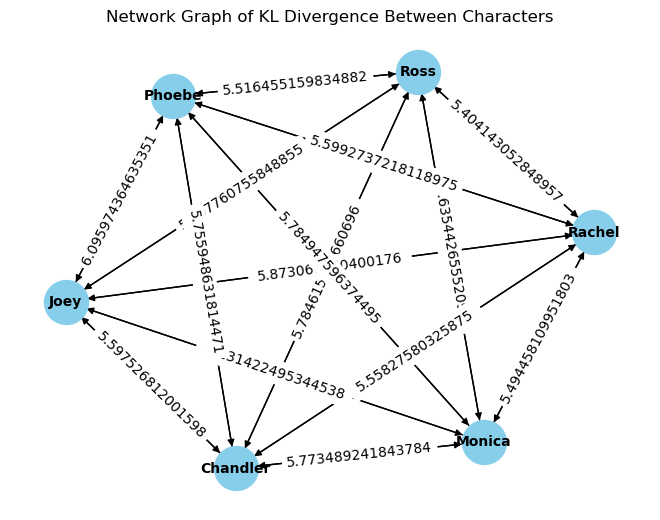

In [4]:
import networkx as nx

# Threshold for including edges in the network graph
threshold = 0.1  # Adjust as needed

# Create a directed graph
G = nx.DiGraph()

# Add nodes to the graph
for char in characters:
    G.add_node(char)

# Add edges to the graph based on the KL divergence values
for i, char1 in enumerate(characters):
    for j, char2 in enumerate(characters):
        if i != j and divergence_matrix[i, j] > threshold:
            G.add_edge(char1, char2, weight=divergence_matrix[i, j])

# Visualize the network graph
pos = nx.spring_layout(G)  # You can use other layouts as well
labels = nx.get_edge_attributes(G, 'weight')
nx.draw(G, pos, with_labels=True, node_size=1000, node_color='skyblue', font_size=10, font_color='black', font_weight='bold')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.title('Network Graph of KL Divergence Between Characters')
plt.show()


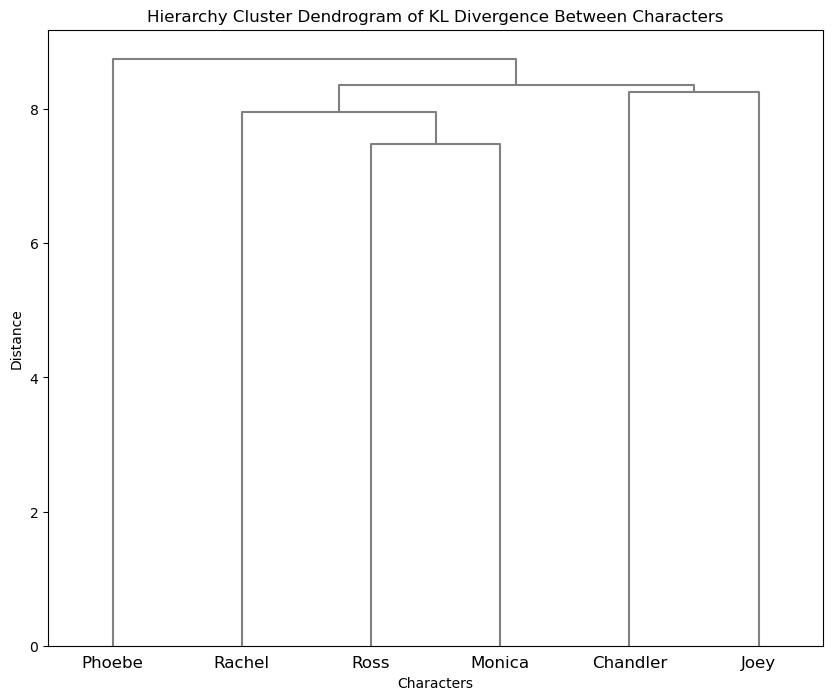

In [5]:
from scipy.cluster.hierarchy import linkage, dendrogram

# Perform hierarchical clustering
linkage_matrix = linkage(divergence_matrix, method='complete')

# Visualize the hierarchy cluster dendrogram
plt.figure(figsize=(10, 8))
dendrogram(linkage_matrix, labels=characters, orientation='top', color_threshold=0.5, above_threshold_color='grey')
plt.title('Hierarchy Cluster Dendrogram of KL Divergence Between Characters')
plt.xlabel('Characters')
plt.ylabel('Distance')
plt.show()


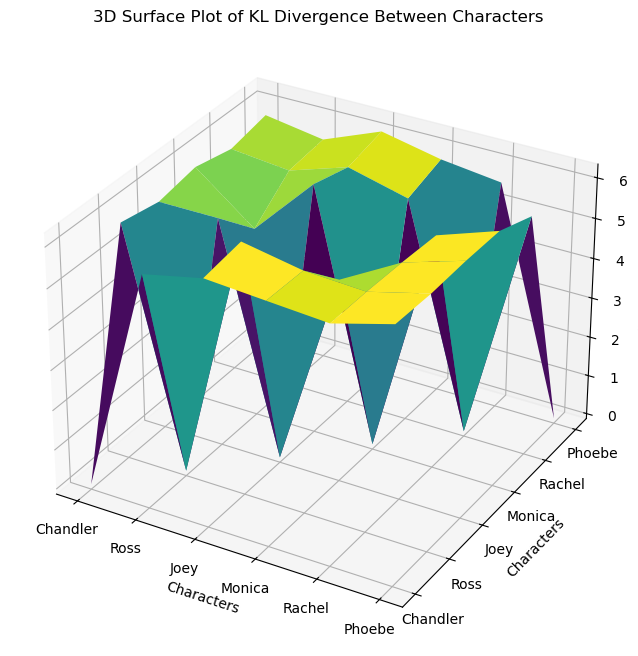

In [6]:
from mpl_toolkits.mplot3d import Axes3D

# Characters to compare
characters = ['Chandler', 'Ross', 'Joey', 'Monica', 'Rachel', 'Phoebe']

# Create a meshgrid for the characters
x, y = np.meshgrid(np.arange(len(characters)), np.arange(len(characters)))

# Create a 3D figure
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the 3D surface
ax.plot_surface(x, y, divergence_matrix, cmap='viridis')

# Customize the plot
ax.set_xticks(np.arange(len(characters)))
ax.set_yticks(np.arange(len(characters)))
ax.set_xticklabels(characters)
ax.set_yticklabels(characters)
ax.set_xlabel('Characters')
ax.set_ylabel('Characters')
ax.set_zlabel('KL Divergence')
ax.set_title('3D Surface Plot of KL Divergence Between Characters')

# Show the plot
plt.show()



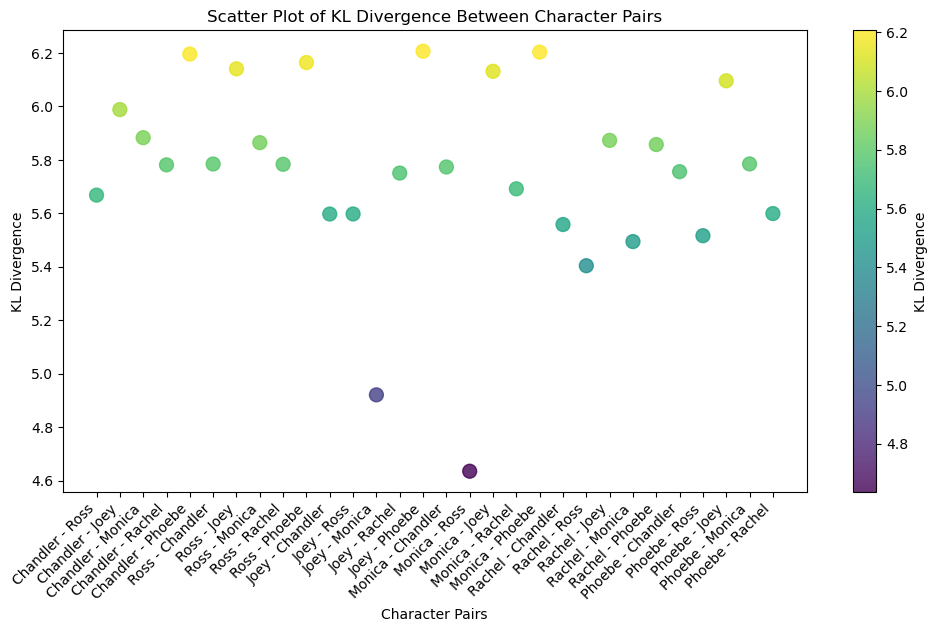

In [7]:
# Characters to compare
characters = ['Chandler', 'Ross', 'Joey', 'Monica', 'Rachel', 'Phoebe']

# Create pairs of character indices for scatter plot
character_pairs = [(i, j) for i in range(len(characters)) for j in range(len(characters)) if i != j]

# Extract KL divergence values and corresponding character pairs
divergence_values = [divergence_matrix[i, j] for i, j in character_pairs]
char_pairs_labels = [f'{characters[i]} - {characters[j]}' for i, j in character_pairs]

# Create a scatter plot
plt.figure(figsize=(12, 6))
plt.scatter(char_pairs_labels, divergence_values, c=divergence_values, cmap='viridis', s=100, alpha=0.8)
plt.title('Scatter Plot of KL Divergence Between Character Pairs')
plt.xlabel('Character Pairs')
plt.ylabel('KL Divergence')
plt.xticks(rotation=45, ha='right')
plt.colorbar(label='KL Divergence')
plt.show()


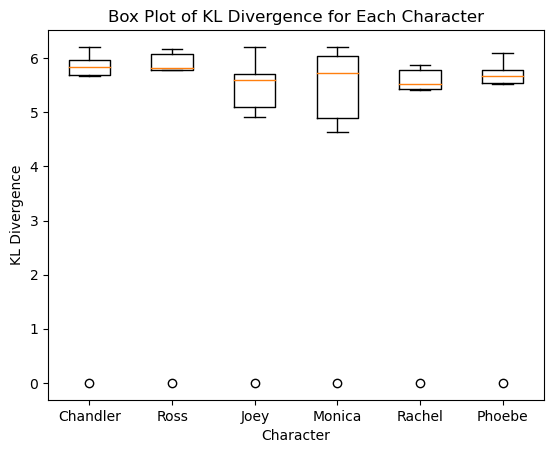

In [8]:
# Box plot to show distribution of KL divergence values for each character
plt.boxplot(divergence_matrix.T, labels=characters)
plt.title('Box Plot of KL Divergence for Each Character')
plt.xlabel('Character')
plt.ylabel('KL Divergence')
plt.show()
